Instructions:

Implement Bayesian inference
1) Randomly generate n (2D) random samples from a MVN with mean [-1, 1]; covariance [2, 1.3; 1.3; 4] 
2) Use Gibbs sampling to infer unknown parameters : mean & covariance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

# 1 Generate Data from MVN

In [2]:
random_seed = 123
rng = np.random.default_rng(random_seed)

In [122]:
μ = np.array([-1, 1])
Σ = np.array([[2, 1.3], [1.3, 4]])
X = np.random.multivariate_normal(μ, Σ, size=1000)

# 2 Bayesian Inference Setup

### Posterior (Normal Inverse Wishart) of $\mu$ and $\Sigma$

(From Murphy)

$$\begin{align}

    p(\mu,\Sigma | D) &= \mathcal{N}(\mu|\mathbf{m}_N, \frac{1}{\kappa_N}\Sigma) \times \mathcal{IW}(\Sigma | \mathbf{S}_N, \nu_N)\\ &= \mathcal{NIW}(\mu,\Sigma | \mathbf{m}_N, \kappa_N, \nu_N, \mathbf{S}_N)\\\\

    m_N &= \frac{\kappa_0\mathbf{m}_0 + N\bar{\mathbf{x}}}{\kappa_0 + N}, \qquad \text{weighted average between prior and observed}\\
    \kappa_N &= \kappa_0 + N\\
    \nu_N &= \nu_0 + N \\
    \mathbf{S}_N &= \mathbf{S}_0 + \mathbf{S}_{\bar{\mathbf{x}}} + \frac{\kappa_0N}{\kappa_0 + N}(\bar{\mathbf{x}} - \mathbf{m}_0)(\bar{\mathbf{x}} - \mathbf{m}_0)^T, \qquad \text{$\bar{x}$ : observed sample mean, use $\mu$ for conditional posterior}\\ 
    &= \mathbf{S}_0 + \mathbf{S} + \kappa_0\mathbf{m}_0\mathbf{m}_0^T - \kappa_N\mathbf{m}_N\mathbf{m}_N^T \\

    \mathbf{S} &= \sum_{i=1}^{N} (\bar{x} - \mu_0)(\bar{x} - \mu_0)^T, \quad \text{use $\mu$ instead of $\bar{x}$ for conditional posterior}
    
\end{align}$$

### Gibbs Routine:
1) Intialize $\mu$ and $\Sigma$ as well as

$$\begin{align}
    \bar{x} &= \frac{1}{N}\sum_{i=0}^N \mathbf{x}_i, & \qquad \text{Observed sample mean}\\
    k_0 &= 0.01, & \qquad \text{prior confidence hyperparameter}\\
    k_n &= k_0 + n & \\ 
    \mu_0 &= \texttt{zero}_d, &\qquad \text{prior belief about mean, hyperparameter}\\
    \nu_0 &= d + 2, &\qquad \text{IW DOF hyperparameter}\\
    \nu_n &= \nu_0 + n, &\\
    S_0 &= M_{identity}, &\qquad \text{Prior believe about scatter matrix}
\end{align}$$


2) for $t=1,...,N$  
$$\begin{align}
    \text{Sample } \mu^{(t)} &\sim \mathcal{N}(\mu|\mathbf{m}_n^{(t)}, \frac{1}{\kappa_n}\Sigma^{(t-1)})\\
        \mu_n &= \frac{k_0\mu_0 + n\bar{x}}{k_0 + n}\\
        \Sigma_n &= \frac{\Sigma^{(t-1)}}{k_n}\\
        \mu^{(t)} &\sim \mathcal{N}(\mu_n, \Sigma_n)\\\\
    
    \text{Sample } \Sigma^{(t)} &\sim \mathcal{IW}(\Sigma | \mathbf{S}_n^{(t)}, \nu_N^{(t)})\\
        S &= \sum_{i=1}^{N} (\mu^{(t)} - \mu_0)(\mu^{(t)} - \mu_0)^T\\
        S_n &= S_0 + S + \frac{\kappa_0n}{\kappa_0 + n}(\mu^{(t)} - \mu_0)(\mu^{(t)} - \mu_0)^T\\
        \Sigma^{(t)} &\sim \mathcal{IW}(S_N, \nu_n)
\end{align}$$


$\qquad$ Keep Samples $\mu^{(t)}$ and $\Sigma^{(t)}$  

3) Discard burn in samples

### 2.1 MVN Approach for Sampling from Wishart

From Murphy  (p. 126) : 

$$\begin{align}
\text{Let $x_i \sim \mathcal{N}(0,\Sigma)$. Then the scatter matrix $\mathbf{S} = \sum_{i=1}^{N}\mathbf{x_i}\mathbf{x_i}^T$ has a Wishart distribution $\mathbf{S} \sim \mathcal{Wi}(\Sigma, N)$. Hence $\mathop{\mathbb{E}}[S] = N\Sigma$.}
\end{align}$$


Hence to sample from Wishart $\mathcal{W}(\nu_n,S_n)$, we generate samples $\mathbf{Z} = [\mathbf{z}_1,...,\mathbf{z}_{\nu_n}]$ from MVN with $\theta = (0, S_n)$, and compute scatter $\mathbf{S} = Z^TZ$ where $\mathbf{S} \sim \mathcal{W}(\nu_n,S_n)$

For inverse Wishart

#### Step 1 : Draw Gaussians 


$\qquad Z \sim \mathcal{N}(0, S_n^{-1})$


$\quad$ where $Z = [z_1,...,z_{v_n}]$

#### Step 2 : Form Wishart 
$\qquad W = Z^TZ \sim \mathcal{W}(\nu, S_n^{-1})$

#### Step 3 : Invert 
$\qquad \Sigma = W^{-1} \sim \mathcal{W}^{-1}(\nu, S_n)$

In [ ]:
def gibbs(X, num_iters, num_burn, eps=1e-14):
    n,d = X.shape

    x_bar = X.mean(axis=0)

    μ_samples = np.zeros((num_iters + num_burn, d))
    Σ_samples = np.zeros((num_iters + num_burn, d, d))

    k_0 = 0.01         # Prior confidence in μ_0
    k_n = k_0 + n      
    μ_0 = np.zeros(d)  # Prior mean vector 
    ν_0 = d + 1        # DOF for inverse wishart
    ν_n = ν_0 + n
    S_0 = np.eye(d)    # positive definite prior scatter matrix

    # Initialize
    Σ_samples[0] = np.cov(X.T)
    μ_samples[0] = x_bar.copy()

    for i in range(1, num_iters + num_burn):
        # Sample μ
        μ_n = (k_0 * μ_0 + n * x_bar) / k_n
        Σ_n = Σ_samples[i-1]/k_n
        μ = np.random.multivariate_normal(mean=μ_n, cov=Σ_n)

        # Sample Σ
        S = (X - μ).T @ (X - μ)
        diff = (μ - μ_0).reshape(-1,1)
        S_n = S_0 + S +(k_0 * n / k_n) * (diff @ diff.T)

        z = np.random.multivariate_normal(np.zeros(d), np.linalg.inv(S_n), size=ν_n)
        W = z.T @ z
        Sigma = np.linalg.inv(W)

        if i == 1 : 
            print(z.shape)

        # Store
        μ_samples[i] = μ
        Σ_samples[i] = Sigma

    return μ_samples[num_burn:], Σ_samples[num_burn:]



In [123]:
mus, sigmas = gibbs(X,10000, 2500)

(1003, 2)
2


In [124]:
print(mus[-1], sigmas[-1])

[-1.00761896  1.05748918] [[2.0225528  1.20941014]
 [1.20941014 4.04484494]]


In [125]:
mu_est = mus.mean(axis=0)
sigma_est = sigmas.mean(axis=0)

print(mu_est, sigma_est)

[-1.00660888  1.10402485] [[1.90786433 1.20578023]
 [1.20578023 3.84053717]]


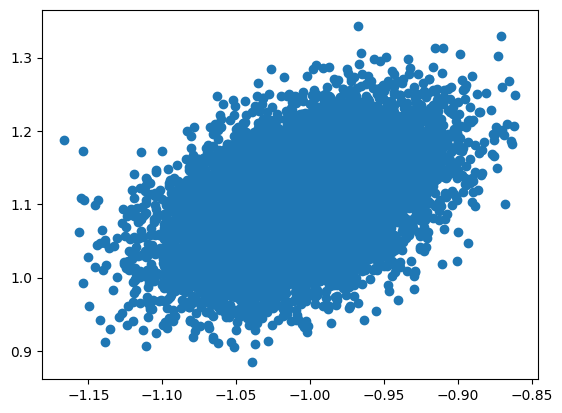

In [126]:
plt.scatter(mus[:,0],mus[:,1])
plt.show()

### 2.2 Bartlett (Cholesky) Decomposition for Sampling from Inverse-Wishart
1. https://en.wikipedia.org/wiki/Wishart_distribution
2. https://djalil.chafai.net/blog/2015/10/20/bartlett-decomposition-and-other-factorizations/



#### Step 1:  Construct lower-trangular matrix T 
$\qquad$ Diagonal Elements  
$$\begin{align}
    T_{ii} \sim \sqrt{\mathcal{X}^2_{\nu  - i + 1}}  \qquad \text{for $i = 1,...,d$}
\end{align}$$

$\qquad$ Below Diagonal Elements  
$$\begin{align}
    T_{ij} \sim \mathcal{N}(0,1), \qquad \text{for $j < i$}
\end{align}$$

$\qquad$ Above Diagonal Elements 
$$\begin{align}
    T_{ij} = 0, \qquad \text{for $j>i$}
\end{align}

#### Step 2 : Compute $A = TT^T$

#### Step 3 : Apply desired scale matrix $S_n$
1) Compute $L = Cholesky(S_n)$, such that $S_n = LL^T$
2) Construct final Wishart sample 
$$\begin{align}
    W = LAL^T \sim \mathcal{W}(S_n, \nu)
\end{align}$$

Inverse Wishart 
$$\begin{align} 
    \mathcal{W}^{-1}(\nu, S_n) \equiv \mathcal{W}(\nu, S_n^{-1})
\end{align}$$

In [138]:
def gibbs(X, num_iters, num_burn, eps=1e-14):
    n,d = X.shape

    x_bar = X.mean(axis=0)

    μ_samples = np.zeros((num_iters + num_burn, d))
    Σ_samples = np.zeros((num_iters + num_burn, d, d))

    k_0 = 0.01
    k_n = k_0 + n
    μ_0 = np.zeros(d)
    ν_0 = d + 1
    S_0 = np.eye(d)
    ν_n = ν_0 + n

    # Initialize
    Σ_samples[0] = np.cov(X.T)
    μ_samples[0] = x_bar.copy()

    for t in range(1, num_iters + num_burn):
        # Sample μ
        μ_n = (k_0 * μ_0 + n * x_bar) / k_n
        Σ_n = Σ_samples[t-1]/k_n
        μ = np.random.multivariate_normal(mean=μ_n, cov=Σ_n)

        # Sample Σ
        S = (X - μ).T @ (X - μ)
        diff = (μ - x_bar)
        S_n = S_0 + S +(k_0 * n / k_n) * (diff @ diff.T)

        # Sample from inverse-wishart with Bartlett decomposition
        T = np.zeros((d, d))

        for i in range(d):
            T[i,i] = np.sqrt(np.random.chisquare(df=ν_n - i))
            if i + 1 < d : 
                T[i + 1:, 1] = np.random.normal(size = d - i - 1)

        A = T @ T.T
        L = np.linalg.cholesky(np.linalg.inv(S_n))
        W = L @ A @ L.T
        Sigma = np.linalg.inv(W)

        # Store
        μ_samples[t] = μ
        Σ_samples[t] = Sigma

    return μ_samples[num_burn:], Σ_samples[num_burn:]

In [153]:
mus, sigmas = gibbs(X,10000, 2500)

In [154]:
print(mus[-1], sigmas[-1])

[-1.00762736  1.08613728] [[1.86009921 1.29557362]
 [1.29557362 4.12820937]]


In [155]:
mu_est = mus.mean(axis=0)
sigma_est = sigmas.mean(axis=0)

print(mu_est, sigma_est)

[-1.00613317  1.10382995] [[1.90518775 1.20603922]
 [1.20603922 3.84266729]]


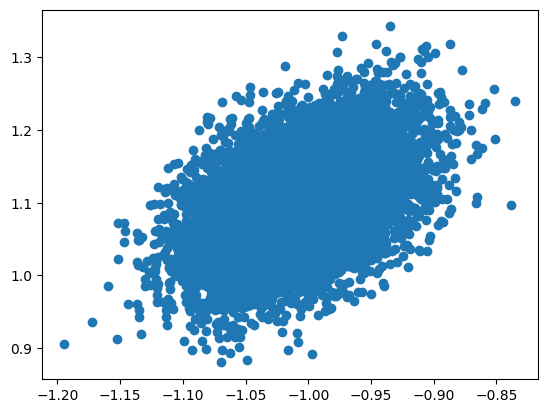

In [156]:
plt.scatter(mus[:,0],mus[:,1])
plt.show()